In [27]:
import math
from collections import Counter
import pandas as pd

# Function to calculate entropy of a dataset
def calculate_entropy(data, target_column):
    """
    Calculate the entropy of the target column in the dataset.

    Parameters:
    data (list of dict): The dataset
    target_column (str): The column for which to calculate entropy

    Returns:
    float: Entropy value
    """
    # Count the occurrences of each class
    class_counts = Counter([row[target_column] for row in data])
    total_rows = len(data)
    entropy = 0.0

    # Calculate entropy using the formula: -sum(p * log2(p))
    for count in class_counts.values():
        probability = count / total_rows
        entropy -= probability * math.log2(probability)

    return entropy

# Function to calculate information gain for an attribute
def calculate_information_gain(data, attribute, target_column):
    """
    Calculate the information gain for splitting on a given attribute.

    Parameters:
    data (list of dict): The dataset
    attribute (str): The attribute to calculate information gain for
    target_column (str): The target column

    Returns:
    float: Information gain value
    """
    # Calculate the total entropy before split (Info(D))
    total_entropy = calculate_entropy(data, target_column)

    # Get all unique values for the attribute
    attribute_values = set([row[attribute] for row in data])

    # Calculate weighted entropy after split (Info_A(D))
    weighted_entropy = 0.0
    total_rows = len(data)

    for value in attribute_values:
        # Split the dataset based on attribute value
        subset = [row for row in data if row[attribute] == value]
        subset_size = len(subset)

        # Calculate entropy for this subset
        subset_entropy = calculate_entropy(subset, target_column)

        # Add to weighted entropy
        weighted_entropy += (subset_size / total_rows) * subset_entropy

    # Information gain = total entropy - weighted entropy after split
    information_gain = total_entropy - weighted_entropy
    return information_gain

# Function to find the best attribute to split on
def find_best_attribute(data, attributes, target_column):
    """
    Find the attribute with the highest information gain.

    Parameters:
    data (list of dict): The dataset
    attributes (list): List of attributes to consider
    target_column (str): The target column

    Returns:
    str: The best attribute for splitting
    """
    best_attribute = None
    max_gain = -1

    for attribute in attributes:
        gain = calculate_information_gain(data, attribute, target_column)
        print(f"Information Gain for {attribute}: {gain:.4f}")

        if gain > max_gain:
            max_gain = gain
            best_attribute = attribute

    return best_attribute

# Function to build the decision tree
def build_decision_tree(data, attributes, target_column, tree=None):
    """
    Recursively build a decision tree using the ID3 algorithm.

    Parameters:
    data (list of dict): The dataset
    attributes (list): List of attributes to consider
    target_column (str): The target column
    tree (dict): The current tree (used for recursion)

    Returns:
    dict: The decision tree
    """
    # Initialize tree if it's the first call
    if tree is None:
        tree = {}

    # Get all target classes in the current dataset
    classes = [row[target_column] for row in data]

    # If all examples have the same class, return that class
    if len(set(classes)) == 1:
        return classes[0]

    # If no attributes left, return the majority class
    if not attributes:
        majority_class = Counter(classes).most_common(1)[0][0]
        return majority_class

    # Find the best attribute to split on
    best_attribute = find_best_attribute(data, attributes, target_column)
    print(f"\nBest attribute to split on: {best_attribute}\n")

    # Create the tree structure with the best attribute
    tree = {best_attribute: {}}

    # Remove the best attribute from the list of attributes
    remaining_attributes = [attr for attr in attributes if attr != best_attribute]

    # Get all unique values of the best attribute
    attribute_values = set([row[best_attribute] for row in data])

    # Recursively build the tree for each value of the best attribute
    for value in attribute_values:
        # Create a subset where the best attribute equals the current value
        subset = [row for row in data if row[best_attribute] == value]

        # If subset is empty, add a leaf node with the majority class
        if not subset:
            majority_class = Counter(classes).most_common(1)[0][0]
            tree[best_attribute][value] = majority_class
        else:
            # Recursively build the subtree
            subtree = build_decision_tree(subset, remaining_attributes, target_column)
            tree[best_attribute][value] = subtree

    return tree

# Function to classify a new instance using the decision tree
def classify(tree, instance):
    """
    Classify a new instance using the decision tree.

    Parameters:
    tree (dict): The decision tree
    instance (dict): The instance to classify

    Returns:
    str: The predicted class
    """
    # If the tree is a leaf node (string), return it as the class
    if isinstance(tree, str):
        return tree

    # Get the attribute at the current node
    attribute = next(iter(tree))
    attribute_value = instance.get(attribute)

    # If the attribute value doesn't exist in the tree, return None
    if attribute_value not in tree[attribute]:
        return None

    # Recursively classify with the subtree
    subtree = tree[attribute][attribute_value]
    return classify(subtree, instance)

# Function to print the decision tree rules
def print_rules(tree, rule=""):
    """
    Print the classification rules from the decision tree.

    Parameters:
    tree (dict): The decision tree
    rule (str): Current rule string (used for recursion)
    """
    # If we've reached a leaf node, print the rule
    if isinstance(tree, str):
        print(f"IF {rule} THEN Class = {tree}")
        return

    # Get the current attribute
    attribute = next(iter(tree))

    # For each value of the attribute, print the rules
    for value, subtree in tree[attribute].items():
        new_rule = f"{rule} AND {attribute} = {value}" if rule else f"{attribute} = {value}"
        print_rules(subtree, new_rule)

# Function to print a text-based visualization of the tree
def print_tree(tree, indent=""):
    """
    Print a text-based visualization of the decision tree.

    Parameters:
    tree (dict): The decision tree
    indent (str): Indentation string (used for recursion)
    """
    # If we've reached a leaf node, print it
    if isinstance(tree, str):
        print(indent + "└── Class:", tree)
        return

    # Get the current attribute
    attribute = next(iter(tree))
    print(indent + attribute)

    # For each value of the attribute, print the subtree
    for value, subtree in tree[attribute].items():
        print(indent + "├──", value)
        print_tree(subtree, indent + "│   ")

# Load dataset from CSV file
df = pd.read_csv("/content/plays_football.csv")

# Convert dataframe to list of dictionaries
data = df.to_dict(orient="records")

# Define attributes and target
attributes = [col for col in df.columns if col not in ["ID", "Class"]]
target_column = "Class"

# Step 1: Calculating Initial Entropy (Info(D))
print("Step 1: Calculating Initial Entropy (Info(D))")
initial_entropy = calculate_entropy(data, target_column)
print(f"Initial Entropy (Info(D)): {initial_entropy:.4f}\n")

# Step 2: Calculating Information Gain for Each Attribute
print("Step 2: Calculating Information Gain for Each Attribute")
for attribute in attributes:
    gain = calculate_information_gain(data, attribute, target_column)
    print(f"Information Gain for {attribute}: {gain:.4f}")

# Step 3: Building the Decision Tree
print("\nStep 3: Building the Decision Tree")
decision_tree = build_decision_tree(data, attributes, target_column)

# Step 4: Decision Tree Rules
print("\nStep 4: Decision Tree Rules")
print_rules(decision_tree)

# Step 5: Text-Based Tree Visualization
print("\nStep 5: Text-Based Tree Visualization")
print_tree(decision_tree)

# Step 6: Classifying a New Instance
print("\nStep 6: Classifying a New Instance")

# Collect valid values for each attribute from dataset
attribute_values = {attr: sorted(set(row[attr] for row in data)) for attr in attributes}

# Prompt user for input with suggestions
print("Please enter values for the following attributes from the available options:")

new_instance = {}
for attribute in attributes:
    options = attribute_values[attribute]
    while True:
        print(f"{attribute} options: {', '.join(options)}")
        value = input(f"{attribute}: ").strip()
        if value in options:
            new_instance[attribute] = value
            break
        else:
            print(f"Invalid input. Please choose one of the available options.")

# Display the new instance
print("New instance to classify:")
for key, value in new_instance.items():
    print(f"{key}: {value}")

# Predict class for the new instance
prediction = classify(decision_tree, new_instance)
print(f"\nPredicted Class: {prediction}")


Step 1: Calculating Initial Entropy (Info(D))
Initial Entropy (Info(D)): 0.9403

Step 2: Calculating Information Gain for Each Attribute
Information Gain for Outlook: 0.2467
Information Gain for Temperature: 0.0292
Information Gain for Humidity: 0.1518
Information Gain for Windy: 0.0161

Step 3: Building the Decision Tree
Information Gain for Outlook: 0.2467
Information Gain for Temperature: 0.0292
Information Gain for Humidity: 0.1518
Information Gain for Windy: 0.0161

Best attribute to split on: Outlook

Information Gain for Temperature: 0.5710
Information Gain for Humidity: 0.9710
Information Gain for Windy: 0.4200

Best attribute to split on: Humidity

Information Gain for Temperature: 0.0200
Information Gain for Humidity: 0.0200
Information Gain for Windy: 0.9710

Best attribute to split on: Windy


Step 4: Decision Tree Rules
IF Outlook = Sunny AND Humidity = High THEN Class = No
IF Outlook = Sunny AND Humidity = Normal THEN Class = Yes
IF Outlook = Rain AND Windy = Strong THEN 

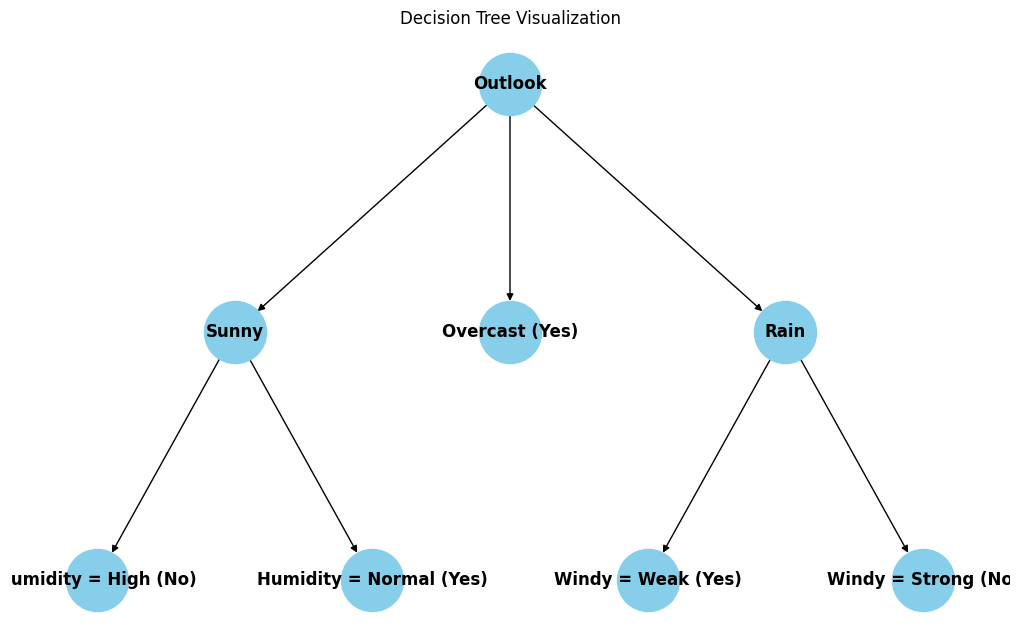

In [23]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph for visualization using NetworkX
G = nx.DiGraph()

# Add nodes and edges based on the decision tree structure
G.add_edges_from([
    ("Outlook", "Sunny"),
    ("Sunny", "Humidity = High (No)"),
    ("Sunny", "Humidity = Normal (Yes)"),
    ("Outlook", "Overcast (Yes)"),
    ("Outlook", "Rain"),
    ("Rain", "Windy = Weak (Yes)"),
    ("Rain", "Windy = Strong (No)")
])

# Positioning the nodes in a hierarchical manner
pos = {
    "Outlook": (0, 3),
    "Sunny": (-2, 2),
    "Humidity = High (No)": (-3, 1),
    "Humidity = Normal (Yes)": (-1, 1),
    "Overcast (Yes)": (0, 2),
    "Rain": (2, 2),
    "Windy = Weak (Yes)": (1, 1),
    "Windy = Strong (No)": (3, 1)
}

# Draw the graph with labels
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=12, font_weight="bold", arrows=True)

# Display the graph
plt.title("Decision Tree Visualization")
plt.show()
